In [94]:
# LOAD LIBRARIES
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import random


# Load libraries for Decision Tree
import pandas as pd
from sklearn.tree import DecisionTreeClassifier  # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split  # Import train_test_split function
from sklearn import metrics  #Import scikit-learn metrics module for accuracy calculation
from sklearn.preprocessing import scale

# Load libraries for Decision Tree Model Plot
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus

# Load libaries for various model performance metrics
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, confusion_matrix, average_precision_score, precision_recall_curve
from matplotlib import pyplot as plt
from inspect import signature

# Load libaries for logistic regression
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
import seaborn as sns
sns.set()
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd

from scipy.spatial import distance


In [143]:
def get_census_data(path_train, path_test):
    # import:
    columns = [
        "age", "workClass", "fnlwgt", "education", "education-num",
        "marital-status", "occupation", "relationship", "race", "sex",
        "capital-gain", "capital-loss", "hours-per-week", "native-country",
        "income"
    ]
    census_train = pd.read_csv(path_train,
                               names=columns,
                               sep=' *, *',
                               na_values='?')
    census_test = pd.read_csv(path_test,
                              names=columns,
                              sep=' *, *',
                              skiprows=1,
                              na_values='?')

    census = pd.concat([census_train, census_test], axis=0)

    # clean:
    census['income'] = census['income'].map(lambda x: x.replace('.', ''))

    census['income_over_50K'] = None
    census.loc[census.income == '<=50K', 'income_over_50K'] = 0
    census.loc[census.income == '>50K', 'income_over_50K'] = 1

    income_over_50K = census.income_over_50K
    census = census.drop(columns=['income_over_50K', 'income'])
    census.insert(0, 'income_over_50K', income_over_50K)

    census = census.drop(columns = ['fnlwgt']) # does not have anything to do with data

    # Making native-country to country_USA feature instead:
    census['country_USA'] = 0
    census.loc[census['native-country'] == 'United-States', 'country_USA'] = 1
    census = census.drop(columns=['native-country'])
    
    census = census.reset_index().drop(columns=['index'])
    
    census_with_dummies = pd.get_dummies(data= census,columns=census.select_dtypes(include=['object']).columns,drop_first=True)

    return census, census_with_dummies

def explore_data(data, label):
    num_attributes = data.select_dtypes(include=['int'])
    print('Numerical features: ' + str(num_attributes.columns))

    num_attributes.hist(figsize=(10,10))

    print(data.describe())

    cat_attributes = data.select_dtypes(include=['object'])
    print('Categorical features: ' + str(cat_attributes.columns))

    for column in cat_attributes:
        if column != 'income':
            sns.countplot(y=column, hue=data[label], data = cat_attributes)
            plt.show()

In [144]:
census, census_with_dummies = get_census_data('adult.data', 'adult.test')

print(census_with_dummies.shape[0] - census_with_dummies.drop(census_with_dummies.sample(n=5).index, axis = 0).shape[0])


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if sys.path[0] == '':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


5


In [147]:
FRACTIONS = {
    'labeled_keep': 0.25,
    'labeled_delete': 0.1,
    'unlabeled': 0.4,
    'unknown': 0.25
}

def divide_data(unsplit_data, fractions = FRACTIONS):
    
    split_data = {}
    
    n_rows = unsplit_data.shape[0]
    remaining = unsplit_data.copy()

    for key in fractions:
        n_rows_key = int(np.floor(fractions[key] * n_rows))
        split_data[key] = remaining.sample(n=n_rows_key)
        
        remaining = remaining.drop(split_data[key].index)
        
    return split_data
    

In [149]:
split_data = divide_data(census_with_dummies, FRACTIONS)
split_data['labeled_keep'].head()

,income_over_50K,age,education-num,capital-gain,capital-loss,hours-per-week,country_USA,workClass_Local-gov,workClass_Never-worked,workClass_Private,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
26182,1,44,13,0,2258,40,1,0,0,0,...,1,0,0,0,0,0,0,0,1,1
47992,0,20,7,0,0,40,1,0,0,1,...,0,0,1,0,0,0,1,0,0,1
27266,0,46,10,0,0,48,1,0,0,1,...,0,0,0,0,0,0,0,0,1,1
17392,0,59,9,0,0,40,1,0,0,1,...,1,0,0,0,0,0,0,0,1,0
3386,0,38,9,3464,0,40,0,0,0,1,...,0,0,0,0,0,0,0,0,1,1


In [153]:
labeled = pd.concat([split_data['labeled_keep'], split_data['labeled_delete']], axis=0)
y = labeled.iloc[:, 0]
X = labeled.drop(labeled.columns[0], axis=1)

k = 1
k = 11
k = 21
k = 31
k = 41
k = 51
k = 61
k = 71
k = 81
k = 91


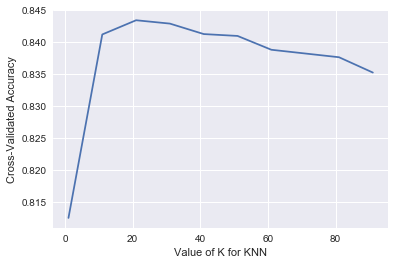

In [158]:
import matplotlib.pyplot as plt 
from sklearn.cross_validation import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

# choose k between 1 to 31
k_range = range(1, 100, 10)
k_scores = []

# use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
for k in k_range:
    print('k = ' + str(k))
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())
# plot to see clearly
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

In [157]:
def KNN_cv(labeled, k_range = range(1, 31, 3)):
    k_scores = []

    # use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
    for k in k_range:
        print('k = ' + str(k))
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
        k_scores.append(scores.mean())
    # plot to see clearly
    plt.plot(k_range, k_scores)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated Accuracy')
    plt.show()